# frameXtract

This notebook walks through the workflow for extracting frames from videos as provided in the utility **frameXtract.py**. Usage of the utility is described in the accompanying [README](https://github.com/MattGrossi-NOAA/SEFSC-FATES-ATI-FrameXtraction#readme) and will not be presented comprehensively here. Rather, this is intended to be more of an explanation of logic in order to facilitate future development and improvement.

## Workflow

### Packages

This package currently has four package dependencies:
1. [**pandas**](https://pandas.pydata.org/docs/index.html), used for handling annotations data speadsheets as DataFrames
2. [**openc-python-headless**](https://pypi.org/project/opencv-python-headless/) (cv2), a container implementation of a Python wrapper for [OpenCV](https://docs.opencv.org/4.x/), an open source computer vision module. This package is used here for reading video and extracting frames from it.
3. [**argparse**](https://docs.python.org/3/library/argparse.html), to support user-provided command line arguments 
4. [**os**](https://docs.python.org/3/library/os.html), an operating system interface library

All external dependencies -- *i.e.*, those not included with standard Python installations -- are listed in the [```requirements.txt```](https://github.com/MattGrossi-NOAA/SEFSC-FATES-ATI-FrameXtraction/blob/main/requirements.txt) file. The only external dependencies so far are [**pandas**](https://pandas.pydata.org/docs/index.html) and [**openc-python-headless**](https://pypi.org/project/opencv-python-headless/).

We first import these package dependencies:

In [1]:
import pandas as pd
import argparse
import cv2
import os

print(f'Pandas version: {pd.__version__}')
print(f'CV2 version: {cv2.__version__}')

Pandas version: 2.1.0
CV2 version: 4.8.1


### Command line arguments and namespace

Command line arguments allow the user to control the behavior of frameXtractor when launched. These are all listed and explained in the [README](https://github.com/MattGrossi-NOAA/SEFSC-FATES-ATI-FrameXtraction/blob/main/README.md). All that needs to be known here is that the Python library [argprase](https://docs.python.org/3/library/argparse.html) creates a Python [namespace](https://docs.python.org/3/library/argparse.html#argparse.Namespace) out of the command line arguments passed by the user. For this demo, since we are not running the program via command line, we will cheat and create our own namespace with some of variable options.

In [2]:
# Fake command line arguments
args = argparse.Namespace()
args.file = 'dummy_data.txt'
args.window = 0
args.print = True
args.sep = '\t'

### Load the data

This utility reads in a spreadsheet that is generated by fish measurement software used by the Southeast Fisheries Science Center (SEFSC). The spreadsheet summarizes species name and fish length for individual fish captured in stereo (left and right channel) video surveys. While the spreadsheet contains several attributes of data and metadata that are not relevant to the task at hand, it must contain the following columns of information in order for this utility to work:
- *FilenameLeft* - name of video files corresponding to left stereo channel
- *FilenameRight* - name of video files corresponding to right stereo channel
- *FrameLeft* - frame numbers to be extracted from *FilenameLeft*
- *FrameRight* - frame numbers to be extracted from *FilenameRight*
- *Length* - length of fish appearing in (*FrameLeft*, *FrameRight*) frame pair
- *Family* - taxonomic family classification of fish appearing in (*FrameLeft*, *FrameRight*) frame pair. If missing, will be filled with "fam".
- *Genus* - taxonomic genus classification of fish appearing in (*FrameLeft*, *FrameRight*) frame pair. If missing, will be filled with "gen".
- *Species* - taxonomic species classification of fish appearing in (*FrameLeft*, *FrameRight*) frame pair. If missing, will be filled with "sp".

Throughout this notebook, the [README](https://github.com/MattGrossi-NOAA/SEFSC-FATES-ATI-FrameXtraction/blob/main/README.md), and the [script itself](https://github.com/MattGrossi-NOAA/SEFSC-FATES-ATI-FrameXtraction/blob/main/frameXtract.py), this spreadsheet is referred to as the *database file* or the *data spreadsheet*.

***

#### Aside: Dummy data

In the absense of having access to actual reef fish video, let's use a stand-in substitute video called "SPOT tagged manta from drone.MOV". (Note: The cell below may not work.)

In [3]:
from IPython.display import Video

Video("./sample_video_mantaray.MOV")

In order for this to work, we need a data spreadsheet that points to this file and has frame numbers that are not out-of-bounds for that video. (The reef fish videos are typically 30 minutes, while this video is only about 30 seconds and therefore contains a fraction of the number of frames.)

We'll create a dummy data spreadsheet by starting with an actual file: "2021_Measurements_Database_Export_2_Lengths.txt". This will ensure we have the correct column names and data structure. We need to read in this spreadsheet file, take the last few rows (for demonstration purposes), replace the video file names with that of the substitute video, and then replace the frame numbers. Again, this is somewhat arbitrary and is for demonstration purposes only.

In [4]:
import numpy as np

# Read in database export file
df = pd.read_csv('2021_Measurements_Database_Export_2_Lengths.txt', delimiter='\t')

# Dummy test dataframe (only need a few rows)
dfNew = df.tail()[:]

# Replace the existing file names with our substitute video
dfNew[['FilenameLeft', 'FilenameRight']] = 'sample_video_mantaray.MOV'

# Specify some frames to be extracted, noting from the file metadata that the video
# has a frame rate of 30 frames/second and is approximately 36 seconds in duration.
dfNew['FrameLeft'] = np.linspace(0, 30*36, num=dfNew.shape[0], dtype=int)
dfNew['FrameRight'] = dfNew['FrameLeft'] + 1

# Write to file
dfNew.to_csv('dummy_data.txt', sep='\t')

# Display the final result to be sure everything worked
display(dfNew)

,OpCode,ImagePtPair,FilenameLeft,FrameLeft,FilenameRight,FrameRight,Time,Period,PeriodTime,Length,...,Family,Genus,Species,Code,Number,Stage,Activity,Comment,Attribute9,Attribute10
1498,942101040,9,sample_video_mantaray.MOV,0,sample_video_mantaray.MOV,1,7.52000,NaN,-1.0,177.02610,...,Lutjanidae,RHOMBOPLITES,AURORUBENS,170152001.0,10,NaN,NaN,NaN,NaN,NaN
1499,942101040,10,sample_video_mantaray.MOV,270,sample_video_mantaray.MOV,271,7.52000,NaN,-1.0,155.75996,...,Lutjanidae,RHOMBOPLITES,AURORUBENS,170152001.0,11,NaN,NaN,NaN,NaN,NaN
1500,942101040,11,sample_video_mantaray.MOV,540,sample_video_mantaray.MOV,541,7.58333,NaN,-1.0,186.63927,...,Lutjanidae,RHOMBOPLITES,AURORUBENS,170152001.0,12,NaN,NaN,NaN,NaN,NaN
1501,942101040,12,sample_video_mantaray.MOV,810,sample_video_mantaray.MOV,811,7.58500,NaN,-1.0,200.13543,...,Lutjanidae,RHOMBOPLITES,AURORUBENS,170152001.0,14,NaN,NaN,NaN,NaN,NaN
1502,942101040,13,sample_video_mantaray.MOV,1080,sample_video_mantaray.MOV,1081,7.58667,NaN,-1.0,191.71676,...,Lutjanidae,RHOMBOPLITES,AURORUBENS,170152001.0,13,NaN,NaN,NaN,NaN,NaN


This is what we will use moving forward (notice that this ```dummy_data.txt``` file was passed to the file command line argument above.)

***

### Load the data

The program first performs some checks to make sure the command line arguments are as expected. For example, the database file name cannot be omitted, and the other flags require certain data types. This won't return anything if everything checks out. Otherwise, the script will exit with an appropriate, and hopefully helpful, error message.

In [5]:
# Sanity checks
if not hasattr(args, 'file'):
    raise NameError(
        'Database file name not found. Use -f or --file to supply a '\
        'file name. See -h for more information.')
elif hasattr(args, 'file') and not isinstance(args.file, str):
    raise TypeError(
        'Expected type str passed to -f or --file but received '\
        f'{type(args.file).__name__}. See -h for more information.')
if hasattr(args, 'video') and not isinstance(args.video, str):
    raise TypeError(
        'Expected type str passed to -v or --video but received '\
        f'{type(args.video).__name__}. See -h for more information.')
if hasattr(args, 'image') and not isinstance(args.image, str):
    raise TypeError(
        'Expected type str passed to -i or --image but received '\
        f'{type(args.video).__name__}. See -h for more information.')
if hasattr(args, 'sep') and not isinstance(args.sep, str):
    raise TypeError(
        'Expected type str passed to -s or --sep but received '\
        f'{type(args.sep).__name__}. See -h for more information.')
if hasattr(args, 'window') and not isinstance(args.window, int):
    raise TypeError(
        'Expected type int passed to -w or --window but received '\
        f'{type(args.window).__name__}. See -h for more information.')
if hasattr(args, 'print') and not isinstance(args.print, bool):
    raise TypeError(
        'Expected type bool passed to -p or --print but received '\
        f'{type(args.print).__name__}. See -h for more information.')

The next step is to figure out how to read in the data. This will be slightly different if the utility is run within as a stand-alone script rather than within its Docker container. The biggest difference is that, when run in a container, the [```docker-compose.yml```](https://github.com/MattGrossi-NOAA/SEFSC-FATES-ATI-FrameXtraction/blob/main/docker-compose.yml) file will contain necessary information such as where to find the video files and where to save the image files. If run separately (not recommended), this information will need be provided by the user or else there will be no way of knowing how to proceed.

Currently, the distinction is made by how the database file is passed: when running in a container, the [```docker-compose.yml```](https://github.com/MattGrossi-NOAA/SEFSC-FATES-ATI-FrameXtraction/blob/main/docker-compose.yml) will include the directory in which this file resides, so the user need only provide the name of the file itself. Without that yml file, the user will need to pass the entire directory chain instead. For example:

*Running as a container:*
```shell
> -f dummy_data.txt
```

*Running stand-alone:*
```shell
> -f /full/path/to/dummy_data.txt
```

This is hardly a foolproof approach, so a later version is likely to have a command line flag to specify how the utility was run, or some other more robust approach.

Another difference is that the directories of the video and image files will be different. If run in a container, these are directories local to the container itself, which are mapped to directories on the host machine in [```docker-compose.yml```](https://github.com/MattGrossi-NOAA/SEFSC-FATES-ATI-FrameXtraction/blob/main/docker-compose.yml). So, if the user does not specify video or image directories in the command line, the program automatically takes them from the container configuration file.

In [6]:
if len(os.path.dirname(args.file)) > 0:
    dbFile = args.file
    container = False
    # if 'video' not in args:
    if not hasattr(args, 'video'):
        raise ValueError(
            'Passing a full directory chain to "-f" or "--file" '\
            'indicates this program is being run stand-alone instead '\
            'of within its container. This requires that the video '\
            'directory be passed to "-v" or "--video", but none was '\
            'detected. See -h for more information.')
    # if 'image' not in args:
    if not hasattr(args, 'image'):
        raise Warning(
            'No image directory was passed to "-i" or "--image". '\
            'Images will be written to the present working directory by '\
            'default.')
else:
    dbFile = os.path.join('/data', args.file)
    container = True
    
# Store video and image directories if running in container
if container:
    args.video = '/videos'
    args.image = '/images'

The program also tries, as a courtesy more than anything else, to determine the delimiter of data spreadsheet from the file extension if the user omits it from the command line. If this fails, the program will exit and the user will be prompted to relaunch while specifying the delimiter.

In [7]:
if not hasattr(args, 'sep'):
    if args.file[-3:] == 'tsv':
        args.sep = '\t'
    elif args.file[-3:] == 'csv':
        args.sep = ','
    else:
        args.sep = None

Now we read in the dummy database file (we only need some of the columns) and fill in any missing species classifications.

In [8]:
try:
    df = pd.read_csv(dbFile, delimiter=args.sep,
                     usecols=['ImagePtPair', 'FilenameLeft', 'FrameLeft',
                              'FilenameRight', 'FrameRight', 'Length',
                              'Family', 'Genus', 'Species', 'Number'])
except ValueError:
    raise ValueError(
        f'Unable to parse the file "{args.file}" using separator '\
        f'"{args.sep}". Relaunch with the proper separator passed '\
        'to -s or --sep flag (e.g., " " for one space, ";" for '\
        'semicolon, etc., without quotations.')

# Fill in missing annotation information
df['Family'].fillna('fam', inplace=True)
df['Genus'].fillna('gen', inplace=True)
df['Species'].fillna('sp', inplace=True)

### Frame extraction

Frame extraction is done using a few nested loops:
- First, loop through both stereo channels.
  - Then loop through each unique video file listed in the spreadsheet. To limit file IO, we'll open each file once and grab all of the desired frames from that video.
    - Next, loop through each of the unique frame numbers to extract from the given video. If the user specified a window of frames before and after the specified frame, then a list of frames is created for each frame in the spreadsheet. For example, if the user specified window=2, then for frame $n$ in the spreadsheet, frames $[n-2, n-1, n, n+1, n+2]$ will be extracted. Otherwise, only the specified frames in the spreadsheet will be extracted.
      - Finally, loop through the list of frame(s) from step 2, extract the frame, and save it to file.

Images are saved to species-specific directories using the taxonomic classification information in the spreadsheet according to the following convention:

```shell
./family/genus/species/videoFileName_frame-N_length-L.jpg
```

where N is the zero-padded frame number extracted from ```videoFileName``` and L is the length of the fish in the image. Note that the species subdirectories are created automatically if they do not already exist, and they are created within the "images" directory specified in [```docker-compose.yml```](https://github.com/MattGrossi-NOAA/SEFSC-FATES-ATI-FrameXtraction/blob/main/docker-compose.yml) or within the image directory passed to the ```-i``` or ```--image``` flag.

In [9]:
# Extract frames from each channel
channels = ['left', 'right']
for channel in channels:
    # Channel
    channel = channel.title()

    # Loop through videos listed in dataframe
    for file, group in df.groupby(f'Filename{channel}'):

        # Zero-padding for frame number in output file name
        pad = len(str(max(group[f'Frame{channel}'])))

        # Video capture
        video = cv2.VideoCapture(os.path.join(args.video, file))

        # Frames to extract from current video
        for dbframe, sample in group.drop_duplicates(subset=f'Frame{channel}',
                                                     keep=False)\
                                    .set_index(f'Frame{channel}').iterrows():
            
            # Create list of frames to extract if a window is supplied
            if hasattr(args, 'window'):
                frames = pd.Series(range(dbframe-args.window,
                                         dbframe+args.window+1)).tolist()
            else:
                frames = [dbframe]
            
            # Loop through each frame in the video
            for frame in frames:
                # Extract frame from video
                video.set(cv2.CAP_PROP_POS_FRAMES, frame)
                success, captured = video.read()
                if success:
                    if args.print:
                        print('Frame {} extracted successfully from {}...'\
                              .format(frame, file))
                else:
                    raise IndexError(
                        f'Error extracting frame {frame} from {file}. '\
                        'Either the file could not be read or the frame '\
                        'could not be extracted. Check the video file and '\
                        'ensure the frame number does not exceed the number '\
                        'of frames in the video.')

                # Save to file
                outPath = os.path.join(
                    args.image,
                    sample['Family'].lower(),
                    sample['Genus'].lower(),
                    sample['Species'].lower())
                print(outPath)
                if not os.path.exists(outPath):
                    print(f'Creating {outPath}')
                    os.makedirs(outPath)
                filePreface = file.split('.')[0].replace(' ', '_')
                outFile = '{}_frame-{}_length-{}.jpg'.format(
                    filePreface,
                    str(frame).zfill(pad),
                    sample['Length'])

                print(os.path.join(outPath, outFile))
                if not cv2.imwrite(os.path.join(outPath, outFile), captured):
                    raise Exception('Could not write image.')
                else:
                    if args.print:
                        print(f'...file {outFile} successfully created.\n')

        # Close video file
        video.release()

Frame 0 extracted successfully from sample_video_mantaray.MOV...
/images/lutjanidae/rhomboplites/aurorubens
/images/lutjanidae/rhomboplites/aurorubens/sample_video_mantaray_frame-0000_length-177.0261.jpg
...file sample_video_mantaray_frame-0000_length-177.0261.jpg successfully created.

Frame 270 extracted successfully from sample_video_mantaray.MOV...
/images/lutjanidae/rhomboplites/aurorubens
/images/lutjanidae/rhomboplites/aurorubens/sample_video_mantaray_frame-0270_length-155.75996.jpg
...file sample_video_mantaray_frame-0270_length-155.75996.jpg successfully created.

Frame 540 extracted successfully from sample_video_mantaray.MOV...
/images/lutjanidae/rhomboplites/aurorubens
/images/lutjanidae/rhomboplites/aurorubens/sample_video_mantaray_frame-0540_length-186.63927.jpg
...file sample_video_mantaray_frame-0540_length-186.63927.jpg successfully created.

Frame 810 extracted successfully from sample_video_mantaray.MOV...
/images/lutjanidae/rhomboplites/aurorubens
/images/lutjanidae

### Verification

Now let's verify that everything worked as intended. We'll print some variables and check the image files we (hopefully!) created.

First, let's see where they should have ended up:

In [10]:
print('SPECIES NAMES:\n', df[['Family', 'Genus', 'Species']].to_string().lower())

SPECIES NAMES:
        family         genus     species
0  lutjanidae  rhomboplites  aurorubens
1  lutjanidae  rhomboplites  aurorubens
2  lutjanidae  rhomboplites  aurorubens
3  lutjanidae  rhomboplites  aurorubens
4  lutjanidae  rhomboplites  aurorubens


In [11]:
print('FRAME NUMBERS:\n', df[['FrameLeft', 'FrameRight']])

FRAME NUMBERS:
    FrameLeft  FrameRight
0          0           1
1        270         271
2        540         541
3        810         811
4       1080        1081


In [12]:
print('LENGTHS:\n', df['Length'])

LENGTHS:
 0    177.02610
1    155.75996
2    186.63927
3    200.13543
4    191.71676
Name: Length, dtype: float64


There is only one species, so a single directory ```./lutjanidae/rhomboplites/aurorubens``` should have been created, and we should have files with the frame numbers and corresponding lengths:

In [13]:
os.listdir('./lutjanidae/rhomboplites/aurorubens')

['sample_video_mantaray_frame-0000_length-177.0261.jpg',
 'sample_video_mantaray_frame-0001_length-177.0261.jpg',
 'sample_video_mantaray_frame-0270_length-155.75996.jpg',
 'sample_video_mantaray_frame-0271_length-155.75996.jpg',
 'sample_video_mantaray_frame-0540_length-186.63927.jpg',
 'sample_video_mantaray_frame-0541_length-186.63927.jpg',
 'sample_video_mantaray_frame-0810_length-200.13543.jpg',
 'sample_video_mantaray_frame-0811_length-200.13543.jpg',
 'sample_video_mantaray_frame-1080_length-191.71676.jpg',
 'sample_video_mantaray_frame-1081_length-191.71676.jpg']

Files exist and the filenames check out. Now let's make sure they actually contain images -- and the frames we desire:

Frame number 0000:


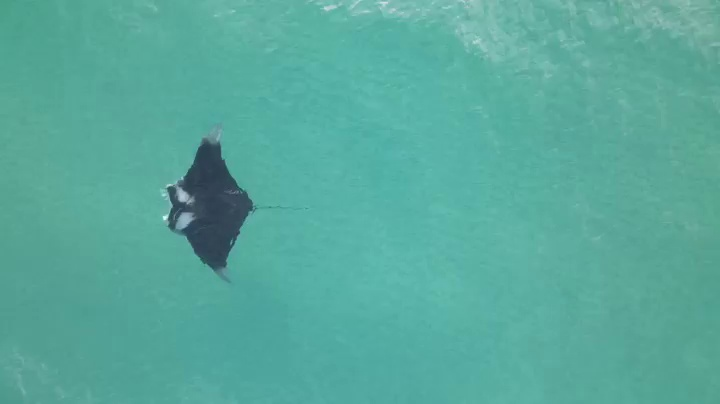

Frame number 0001:


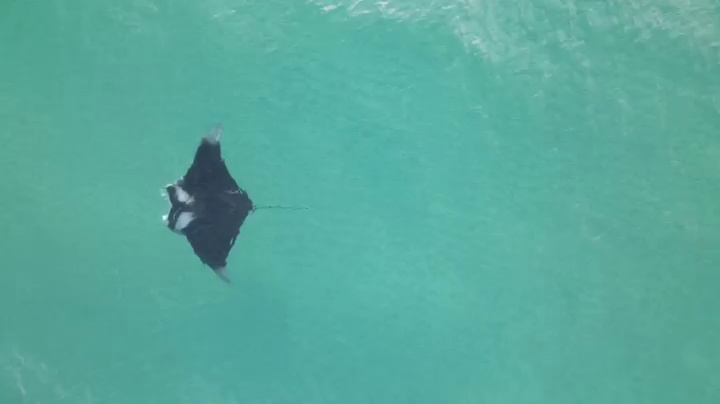

Frame number 0270:


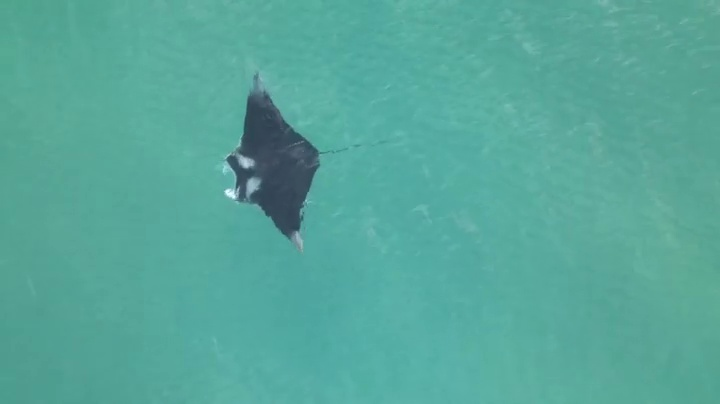

Frame number 0271:


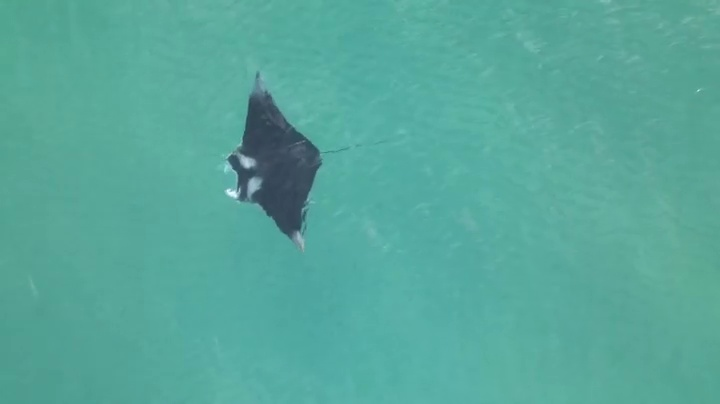

Frame number 0540:


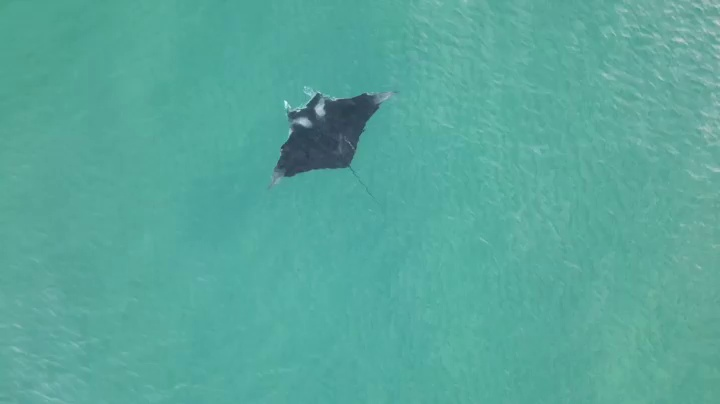

Frame number 0541:


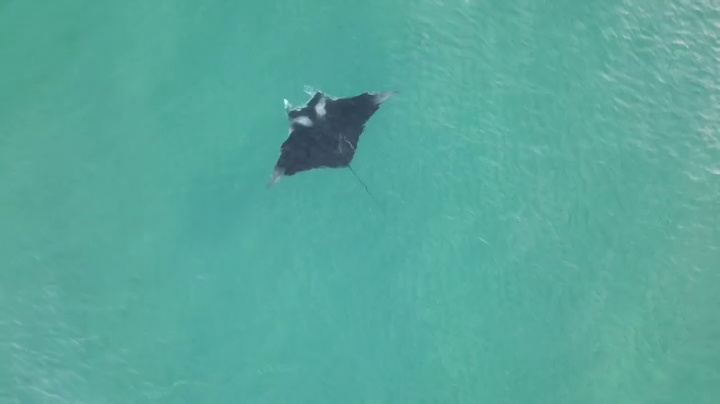

Frame number 0810:


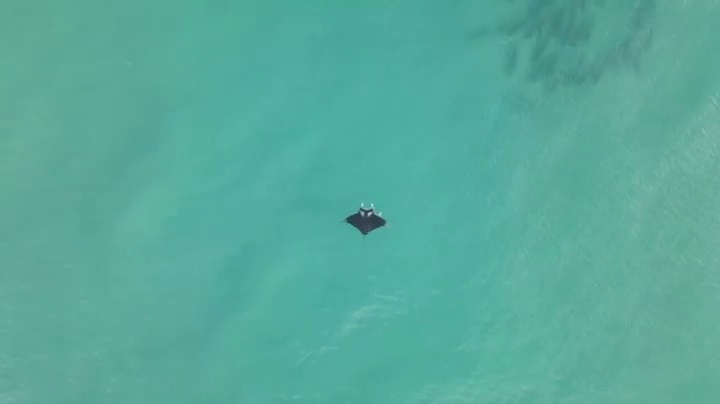

Frame number 0811:


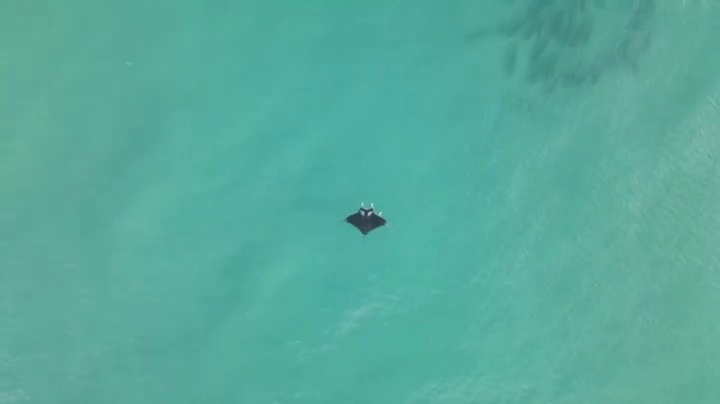

Frame number 1080:


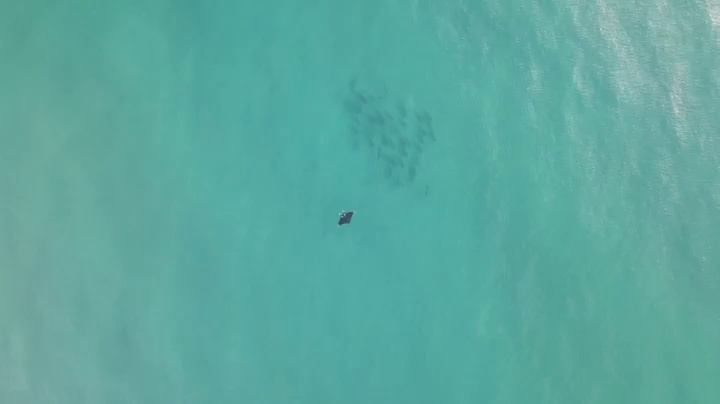

Frame number 1081:


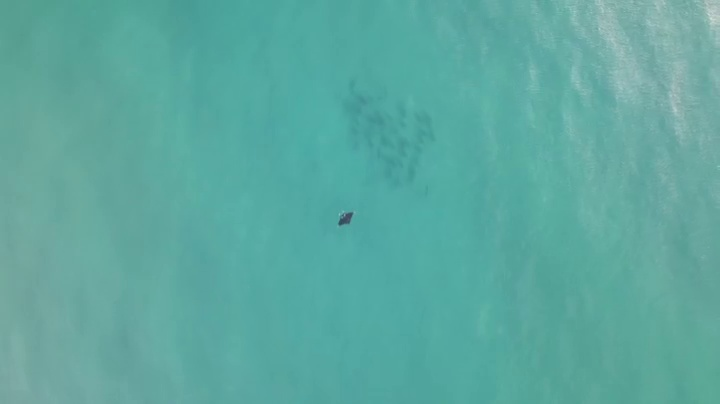

In [14]:
from IPython.display import Image, display

outDir = './lutjanidae/rhomboplites/aurorubens'
for file in os.listdir(outDir):
    print(f"Frame number {file.split('_')[-2].split('-')[1]}:")
    display(Image(os.path.join(outDir, file)))

Comparing this to the video above, everything checks out.

### Conclusion

We have seen how **frameXtractor.py** can be used to extract frames from a video and save those to file. Instructions on how to use the utility can be found in the [documentation](https://mattgrossi-noaa.github.io/SEFSC-FATES-ATI-FrameXtraction) or on the main GitHub [repo landing page](https://github.com/MattGrossi-NOAA/SEFSC-FATES-ATI-FrameXtraction). If you encounter any issues or would like to submit feature requests, please consider [opening an issue](https://github.com/MattGrossi-NOAA/SEFSC-FATES-ATI-FrameXtraction/issues).

***

## Disclaimer

This software and its repository is a scientific product and is not official communication of the National Oceanic and Atmospheric Administration, or the United States Department of Commerce. All NOAA GitHub project code is provided on an "as is" basis and the user assumes responsibility for its use. Any claims against the Department of Commerce or Department of Commerce bureaus stemming from the use of this GitHub project will be governed by all applicable Federal law. Any reference to specific commercial products, processes, or services by service mark, trademark, manufacturer, or otherwise, does not constitute or imply their endorsement, recommendation or favoring by the Department of Commerce. The Department of Commerce seal and logo, or the seal and logo of a DOC bureau, shall not be used in any manner to imply endorsement of any commercial product or activity by DOC or the United States Government.

***